# Know your model

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Running in Google Colab environment")
    !pip install mace-torch
    !pip install torch-dftd
    !git clone https://github.com/ChengUCB/les.git && cd les && pip install -e .

    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Not running in Colab")

In [ ]:
import sys
if IN_COLAB:
    sys.path.insert(0, '/content/drive/MyDrive/s25-cm5100/s25-cm5100/data/')
    root_path = '/content/drive/MyDrive/s25-cm5100/s25-cm5100/data'
else:
    sys.path.insert(0, '../data/')
    root_path = '../data/'

## Load pre-trained models

In [ ]:
import os
import sys

from mace.calculators import mace_mp
from ase.calculators.mixing import SumCalculator
import numpy as np
import torch
import numpy as np
from ase import Atoms
from ase import units
from ase.visualize import view
from torch_dftd.torch_dftd3_calculator import TorchDFTD3Calculator

from ml import plot_mat

# Pretrained foundation model
calculator_1 = mace_mp(model="medium", device="cpu")
d3_calc = TorchDFTD3Calculator(
        device="cpu",
        damping="zero",
        dtype=torch.float32,
        xc="pbe",
        cutoff=40 * units.Bohr,
    )

calculator_1_dftd3 = SumCalculator([calculator_1, d3_calc])

# Self-trained model
calculator_2 = mace_mp(model=os.path.join(root_path, "ml/PdAgCHO_mace.model_stagetwo.model"), device="cpu")

# Correctional model 
from mace.modules import extensions
sys.modules['mace.modules.models'].MACELES = extensions.MACELES
calculator_2_lr = mace_mp(model=os.path.join(root_path, "ml/PdAgCHO_mace_lr_0901.model"), device="cpu")

# DFT calculator
from ase.calculators.vasp import Vasp
os.environ["VASP_PP_PATH"] = "/Users/c_yang/OneDrive/package/vasp/"
os.environ["VASP_COMMAND"] = "mpirun -n 10 /Users/c_yang/opt/vasp/vasp.6.5.1/bin/vasp_std"
calculator_3 = Vasp(setups="recommended", directory="gas_test", xc="PBE", encut=450, kpts=[1, 1, 1], ismear=0, sigma=0.01, lreal="Auto", ediff=1e-5, ediffg=-0.02, nsw=0, ivdw=11)

Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Using head default out of ['default']
Default dtype float32 does not match model dtype float64, converting models to float32.
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Using head default out of ['default']
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


/Users/c_yang/repo/mace/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/Users/c_yang/repo/mace/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/Users/c_yang/repo/mace/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head default out of ['default']


## Benchmark

## Bonding energy

In [2]:
gas_molecules = ["CO", "H2", "O2", "CH", "CC"]

positions_A = np.array([0, 0, 0])
positions_B = np.linspace(0.6, 3.0, 30)[:, np.newaxis] * np.array([1, 0, 0])
positions_B_dft = np.linspace(0.6, 3.0, 5)[:, np.newaxis] * np.array([1, 0, 0])

In [3]:
atoms = Atoms("CO", positions=[positions_A, positions_B[0]], cell=[20, 20, 21], pbc=[True, True, True])
tuple(atoms.get_pbc())

(np.True_, np.True_, np.True_)

In [10]:
%%time
energies_foundation = {}
for gas in gas_molecules:
    energies_foundation[gas] = {}
    energies_foundation[gas]["energy"] = []
    energies_foundation[gas]["forces"] = []

    for p in positions_B:
        atoms = Atoms(gas, positions=[positions_A, p], cell= [20, 20, 21], pbc=[True, True, True])
        atoms.calc = calculator_1
        energies_foundation[gas]["energy"].append(atoms.get_potential_energy())
        energies_foundation[gas]["forces"].append(atoms.get_forces())


CPU times: user 1.79 s, sys: 629 ms, total: 2.42 s
Wall time: 1.97 s


In [11]:
%%time
energies_foundation_dftd3 = {}
for gas in gas_molecules:
    energies_foundation_dftd3[gas] = {}
    energies_foundation_dftd3[gas]["energy"] = []
    energies_foundation_dftd3[gas]["forces"] = []
    for p in positions_B:
        atoms = Atoms(gas, positions=[positions_A, p], cell= [20, 20, 21], pbc=[1, 1, 1])
        atoms.calc = calculator_1_dftd3
        energies_foundation_dftd3[gas]["energy"].append(atoms.get_potential_energy())
        energies_foundation_dftd3[gas]["forces"].append(atoms.get_forces())


CPU times: user 2.06 s, sys: 659 ms, total: 2.72 s
Wall time: 2.27 s


In [14]:
%%time
energies_PdAgCHO = {}
for gas in gas_molecules:
    energies_PdAgCHO[gas] = {}
    energies_PdAgCHO[gas]["energy"] = []
    energies_PdAgCHO[gas]["forces"] = []
    for p in positions_B:
        atoms = Atoms(gas, positions=[positions_A, p], cell= [20, 20, 21], pbc=[1, 1, 1])
        atoms.calc = calculator_2
        energies_PdAgCHO[gas]["energy"].append(atoms.get_potential_energy())
        energies_PdAgCHO[gas]["forces"].append(atoms.get_forces())

CPU times: user 5.66 s, sys: 1.89 s, total: 7.55 s
Wall time: 5.49 s


In [15]:
%%time
energies_PdAgCHO_lr = {}
for gas in gas_molecules:
    energies_PdAgCHO_lr[gas] = {}
    energies_PdAgCHO_lr[gas]["energy"] = []
    energies_PdAgCHO_lr[gas]["forces"] = []
    for p in positions_B:
        atoms = Atoms(gas, positions=[positions_A, p], cell= [20, 20, 21], pbc=[1, 1, 1])
        atoms.calc = calculator_2_lr
        energies_PdAgCHO_lr[gas]["energy"].append(atoms.get_potential_energy())
        energies_PdAgCHO_lr[gas]["forces"].append(atoms.get_forces())

CPU times: user 5.76 s, sys: 1.87 s, total: 7.63 s
Wall time: 5.54 s


In [ ]:
# %%time
# energies_DFT = {}
# for gas in gas_molecules:
#     energies_DFT[gas] = []
#     for p in positions_B_dft:
#         atoms = Atoms(gas, positions=[positions_A, p], cell= [20, 20, 21], pbc=[1, 1, 1])
#         atoms.calc = calculator_3
#         energies_DFT[gas].append(atoms.get_potential_energy())

CPU times: user 290 ms, sys: 347 ms, total: 638 ms
Wall time: 50min 40s


/Users/c_yang/opt/conda/envs/mace/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/c_yang/opt/conda/envs/mace/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


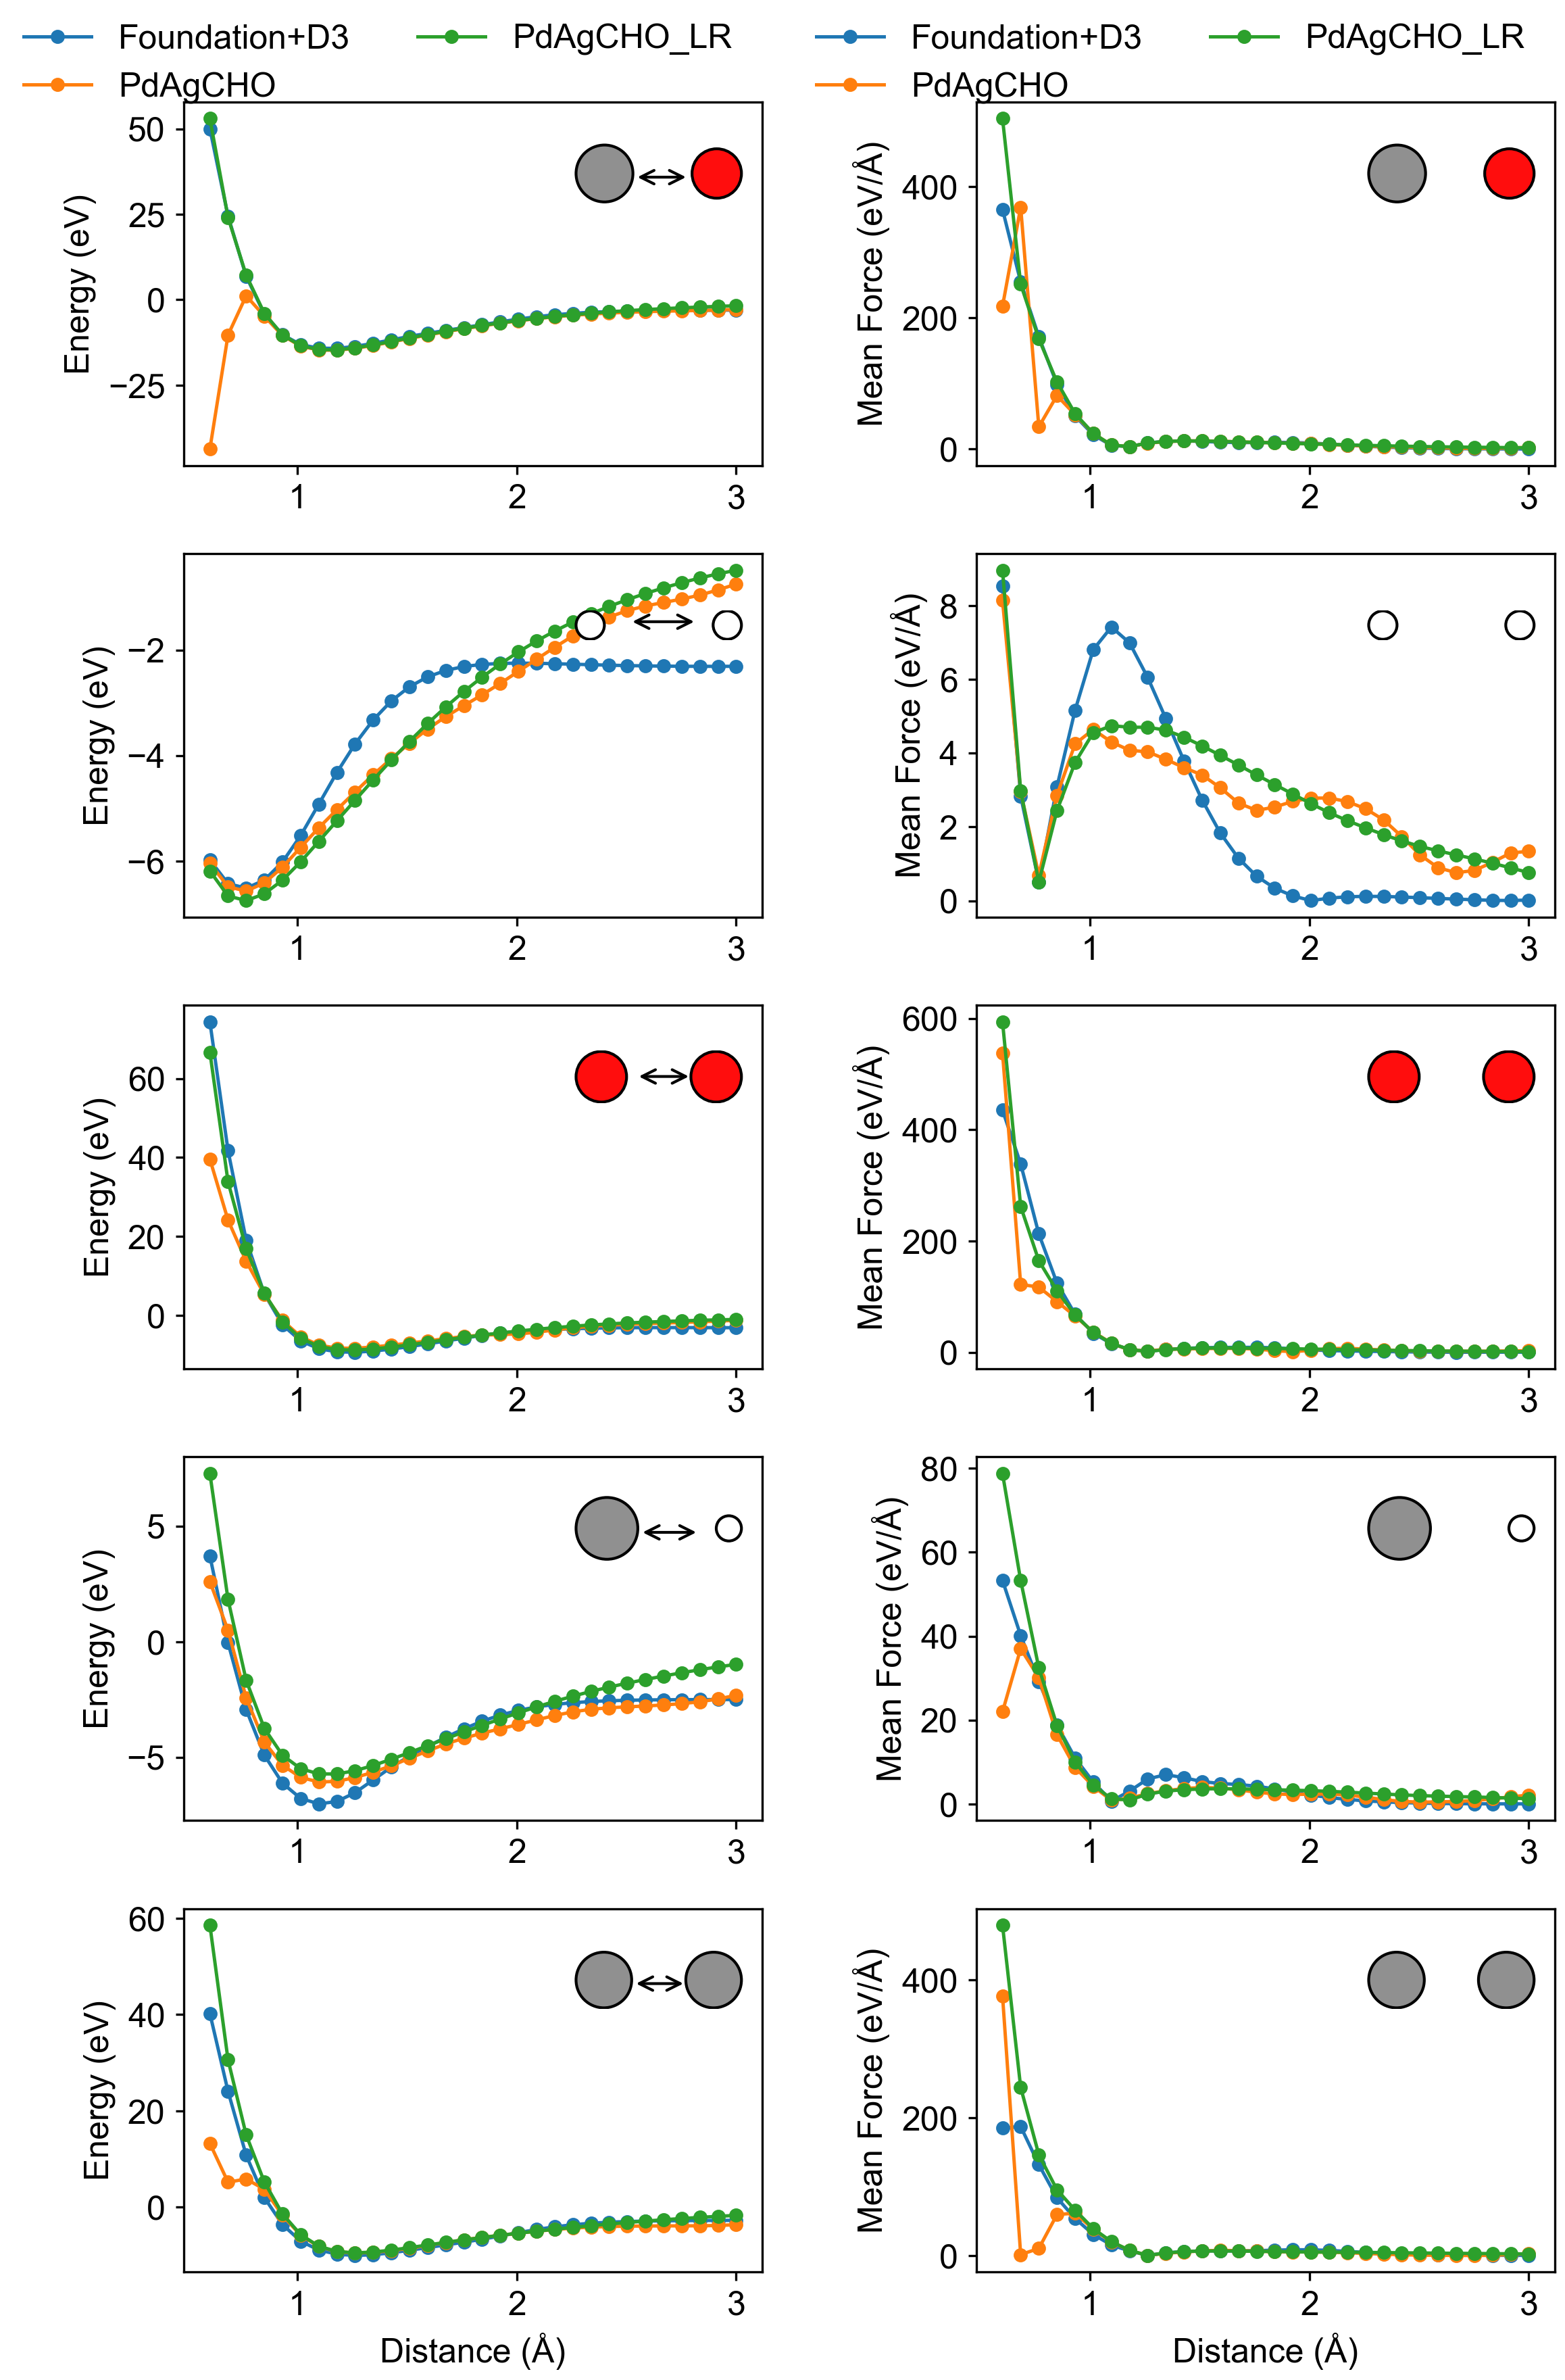

In [ ]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from ase.visualize.plot import plot_atoms
plt.style.use("acs")

fig, ax = plt.subplots(5, 2, figsize=(8,12), tight_layout=True)
calc_name = ["Foundation+D3", "PdAgCHO", "PdAgCHO_LR", "DFT"]

if os.path.exists(os.path.join(root_path, "ml/dft_bond_energy.json")):
    from monty.serialization import loadfn
    energies_DFT = loadfn(os.path.join(root_path, "ml/dft_bond_energy.json"))

for i, gas in enumerate(gas_molecules):
    for j, ene in enumerate([energies_foundation_dftd3, energies_PdAgCHO, energies_PdAgCHO_lr, energies_DFT]):
        try:
            ax[i][0].plot(positions_B[:, 0], ene[gas]["energy"], label=calc_name[j], marker="o",)
            ax[i][1].plot(positions_B[:, 0], np.mean(np.linalg.norm(ene[gas]["forces"], axis=2), axis=1), label=calc_name[j], marker="o",)
        except:
            ax[i][0].plot(positions_B[:, 0], ene[gas], label=calc_name[j], marker="o",)
        finally:
            pass
    inax = inset_axes(ax[i][0], width="30%", height="30%", loc="upper right")
    inax_1 = inset_axes(ax[i][1], width="30%", height="30%", loc="upper right")
    plot_atoms(Atoms(gas, positions=[positions_A, positions_B[-1]]), ax=inax, show_unit_cell=2)
    plot_atoms(Atoms(gas, positions=[positions_A, positions_B[-1]]), ax=inax_1, show_unit_cell=2)
    if gas == "H2":
        inax.annotate(
       '', xy=(2.8, 0.4), xytext=(1.2, 0.4),
        arrowprops=dict(arrowstyle='<->', color='k', lw=1)
    )
    else:
        inax.annotate(
        '', xy=(3.2, 0.7), xytext=(1.6, 0.7),
        arrowprops=dict(arrowstyle='<->', color='k', lw=1)
    )
    inax.set_axis_off()
    inax_1.set_axis_off()
    #ax[i].legend(loc="upper left")
    #ax[i].set_xlabel("Distance (Å)")
    #ax[i].set_ylim(-20, 20)
    ax[i][0].set_ylabel("Energy (eV)")
    ax[i][1].set_ylabel("Mean Force (eV/Å)")
    #ax[i].set_title(f"Bonding energy of {gas} calculated by MACE")
ax[4][0].set_xlabel("Distance (Å)")
ax[4][1].set_xlabel("Distance (Å)")
ax[0][0].legend(loc="upper right", bbox_to_anchor=(1, 1.3), ncol=2)
ax[0][1].legend(loc="upper right", bbox_to_anchor=(1, 1.3), ncol=2)

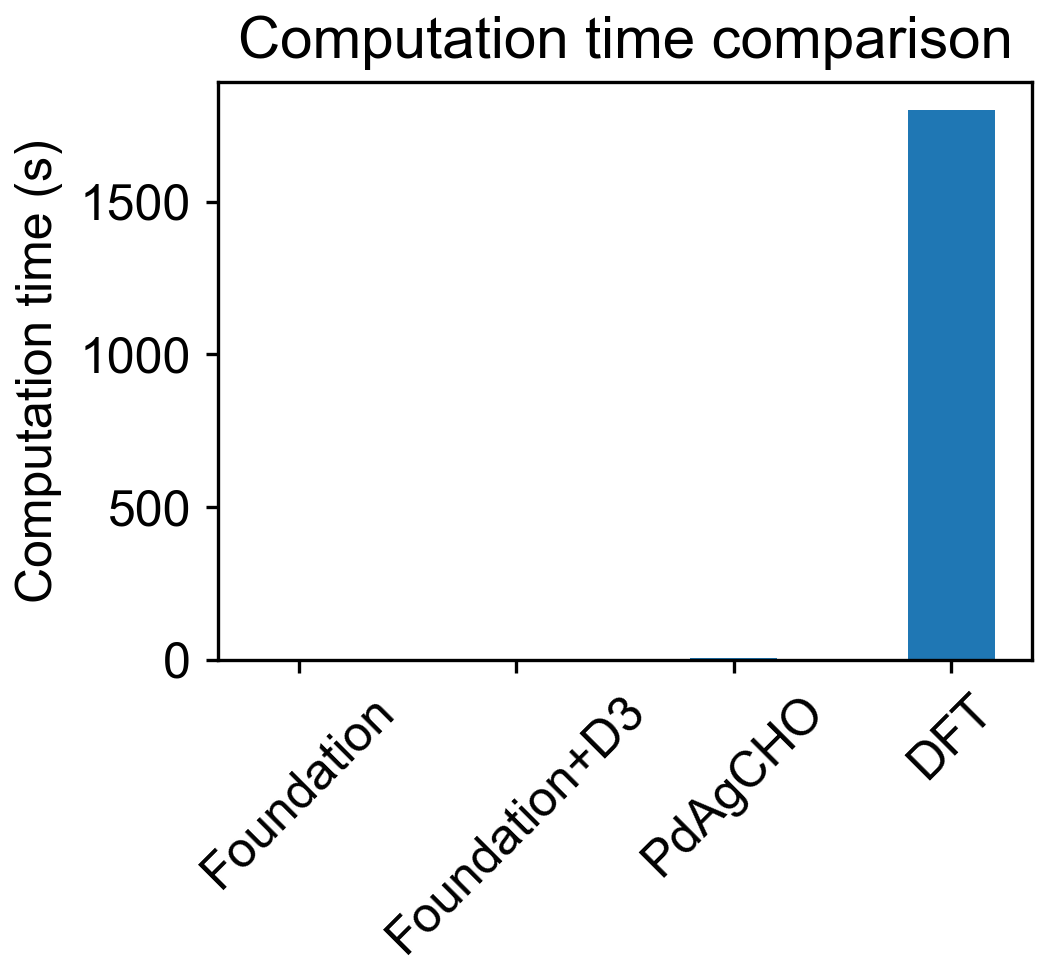

In [41]:
plt.bar([1, 2, 3, 4], [2.19, 2.08, 5.84, 1800], width=0.4)
plt.xticks([1, 2, 3, 4], ["Foundation", "Foundation+D3", "PdAgCHO", "DFT"], rotation=45)
plt.ylabel("Computation time (s)")
plt.title("Computation time comparison")
plt.show()

## Chemical reaction

### CO + H2O -> *COH + *OH

In [49]:
# Pd
from ase.build import fcc111, add_adsorbate
from ase.constraints import FixAtoms

# Generate the Pd(111) slab
slab = fcc111('Pd', size=(4, 4, 4), vacuum=7.5, periodic=True, orthogonal=True)

# Fix the bottom two layers
center_pos = slab.positions[:, 2].mean()
fix_indices = [atom.index for atom in slab if atom.position[2] < center_pos + 0.2]
slab.set_constraint(FixAtoms(indices=fix_indices))

max_z = slab.positions[:, 2].max()
surface_index = np.where(slab.positions[:, 2] > max_z - 0.1)[0]

# Add CO and H2O
CO = Atoms("CO", positions=[[0, 0, 0], [0, 0, 1.128]])
H2O = Atoms("OH2", positions=[[0, 0, 0], [0.7586, 0, 0.5043], [-0.7586, 0, 0.5043]])

site_A = slab.positions[surface_index[0]]
site_B = slab.positions[surface_index[1]]
tmp_slab = slab.copy()
add_adsorbate(tmp_slab, CO, 1.85, position=site_A[:2])
add_adsorbate(tmp_slab, H2O, 1.85, position=site_B[:2])
slab_CO_H2O = tmp_slab.copy()

# # Add COH and OH
CHO = Atoms("COH", positions=[[0, 0, 0], [0, 0, 1.19],  [0, 1.1, 0.2]])
OH = Atoms("OH", positions=[[0, 0, 0], [0, 0, 0.96]])

tmp_slab = slab.copy()
add_adsorbate(tmp_slab, CHO, 1.85, position=site_A[:2])
add_adsorbate(tmp_slab, OH, 1.85, position=site_B[:2])
slab_CHO_OH = tmp_slab.copy()
# slab_COH = add_adsorbate(slab.copy(), COH, 1.85, 'ontop')
# slab_COH_OH = add_adsorbate(slab_COH, OH, 1.85, 'ontop')

Text(0.5, 1.0, 'Optimized structures on Pd(111) surface')

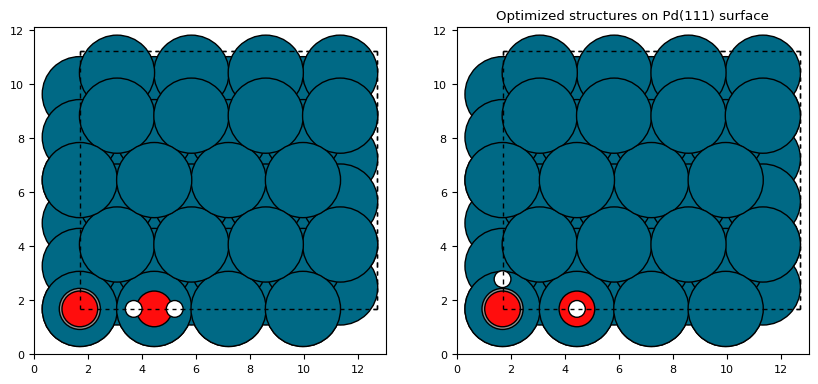

In [53]:
from matplotlib import pyplot as plt
from ase.visualize.plot import plot_atoms
fig, ax = plt.subplots(1, 2, figsize=(10,5))
plot_atoms(slab_CO_H2O, rotation='00x,0y,0z', ax=ax[0], show_unit_cell=2)
plot_atoms(slab_CHO_OH, rotation='00x,0y,0z', ax=ax[1], show_unit_cell=2)
plt.title("Optimized structures on Pd(111) surface")

Foundation slab_CO_H2O energy: -344.2897033691406 eV
Foundation slab_COH_OH energy: -342.686767578125 eV
Foundation+D3 slab_CO_H2O energy: -371.0713850518473 eV
Foundation+D3 slab_COH_OH energy: -369.47282278369346 eV
PdAgCHO_LR slab_CO_H2O energy: -379.97509765625 eV
PdAgCHO_LR slab_COH_OH energy: -379.34619140625 eV


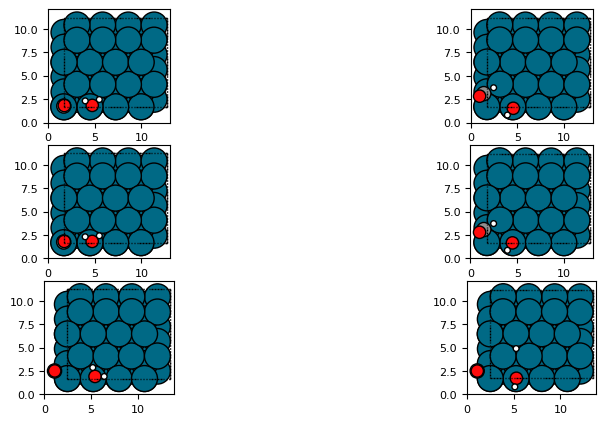

In [54]:
from ase.optimize import BFGS
try:
    os.mkdir("slab_test")
except FileExistsError:
    pass

### Optimize both two structures
energies_reaction = {}
fig, ax = plt.subplots(3, 2, figsize=(10,5))
calc_name = ["Foundation", "Foundation+D3", "PdAgCHO_LR"]
for i, calc in enumerate([calculator_1, calculator_1_dftd3, calculator_2_lr]):
    energies_reaction[f"{calc_name[i]}"] = {}
    for struc in ["slab_CO_H2O", "slab_COH_OH"]:
        if struc == "slab_CO_H2O":
            slab = slab_CO_H2O
            j = 0
        else:
            slab = slab_CHO_OH
            j = 1
        slab.calc = calc
        opt = BFGS(slab, trajectory=f"./slab_test/{struc}_{calc_name[i]}.traj", logfile=f"./slab_test/{struc}_{calc_name[i]}.log")
        opt.run(fmax=0.02, steps=200)
        energy = slab.get_potential_energy()
        energies_reaction[f"{calc_name[i]}"][f"{struc}"] = energy
        print(f"{calc_name[i]} {struc} energy: {energy} eV")
        plot_atoms(slab, rotation='00x,0y,0z', ax=ax[i][j], show_unit_cell=2)


Text(0.5, 1.0, 'Optimized structures on Pd(111) surface')

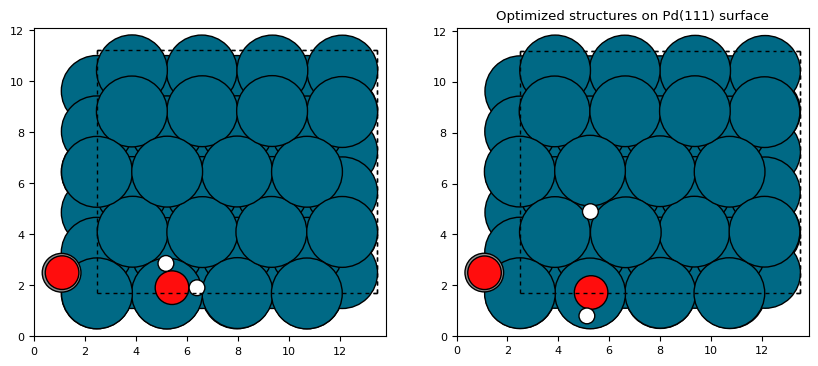

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
plot_atoms(slab_CO_H2O, rotation='00x,0y,0z', ax=ax[0], show_unit_cell=2)
plot_atoms(slab_CHO_OH, rotation='00x,0y,0z', ax=ax[1], show_unit_cell=2)

plt.title("Optimized structures on Pd(111) surface")

In [ ]:
view(slab_CO_H2O, viewer="x3d")

NameError: name 'slab_CO_H2O' is not defined

Foundation CO + H2O -> COH + OH reaction energy: 1.602935791015625 eV
Foundation+D3 CO + H2O -> COH + OH reaction energy: 1.5985622681538416 eV
PdAgCHO_LR CO + H2O -> COH + OH reaction energy: 0.62890625 eV


Text(0.5, 1.0, 'CO + H2O -> COH + OH reaction energy on Pd(111) surface')

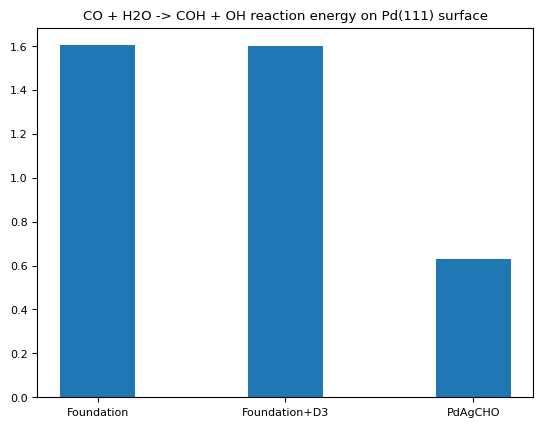

In [56]:
## Calculator the reaction energy
reaction_bar = []
for calc in calc_name:
    delta_E = energies_reaction[calc]["slab_COH_OH"] - energies_reaction[calc]["slab_CO_H2O"]
    print(f"{calc} CO + H2O -> COH + OH reaction energy: {delta_E} eV")
    reaction_bar.append(delta_E)

plt.bar(["Foundation", "Foundation+D3", "PdAgCHO"], reaction_bar, width=0.4)
plt.title("CO + H2O -> COH + OH reaction energy on Pd(111) surface")

### Calculator the reaction energy

In [78]:
from copy import copy,deepcopy
from ase.io import read

slab_CO_H2O = read(f"./slab_test/slab_CO_H2O_Foundation+D3.traj")
slab_CHO_OH = read(f"./slab_test/slab_COH_OH_Foundation+D3.traj")
tmp_atom_sym = copy(slab_CHO_OH[-3].symbol)
tmp_atom_pos = copy(slab_CHO_OH[-3].position)
slab_CHO_OH[-3].symbol = copy(slab_CHO_OH[-2].symbol)
slab_CHO_OH[-3].position = copy(slab_CHO_OH[-2].position)
slab_CHO_OH[-2].symbol = tmp_atom_sym
slab_CHO_OH[-2].position = tmp_atom_pos

tmp_atom_sym = copy(slab_CHO_OH[-1].symbol)
tmp_atom_pos = copy(slab_CHO_OH[-1].position)
slab_CHO_OH[-1].symbol = copy(slab_CHO_OH[-2].symbol)
slab_CHO_OH[-1].position = copy(slab_CHO_OH[-2].position)
slab_CHO_OH[-2].symbol = tmp_atom_sym
slab_CHO_OH[-2].position = tmp_atom_pos
#view([slab_CO_H2O, slab_CHO_OH])


In [ ]:
from ase.mep import NEB
from copy import copy,deepcopy

images = [slab_CO_H2O.copy()] + [slab_CO_H2O.copy() for i in range(5)] + [slab_CHO_OH.copy()]
for img in images:
    img.calc = copy(calculator_1_dftd3)

neb = NEB(images)
neb.interpolate(method='idpp')

from ase.optimize import BFGS
opt = BFGS(neb, trajectory="./slab_test/neb_Foundation+D3.traj", logfile="./slab_test/neb_Foundation+D3.log")
opt.run(fmax=0.05, steps = 500)

1.7964701705961943 1.5985622681538416 0.21486893763878337


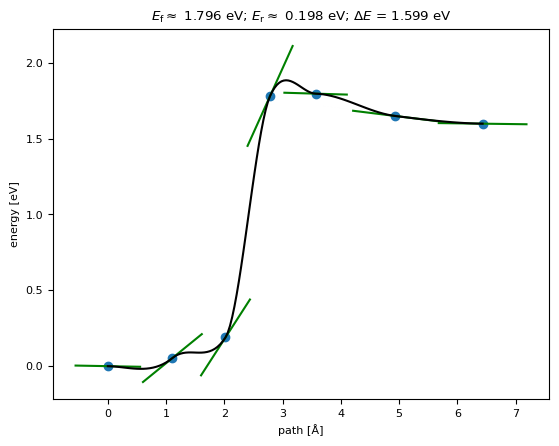

In [82]:
from ase.mep import NEBTools

nebtools = NEBTools(neb.images)
# Get the calculated barrier and the energy change of the reaction.
Ef, dE = nebtools.get_barrier()

# Get the barrier without any interpolation between highest images.
Ef, dE = nebtools.get_barrier(fit=False)

# Get the actual maximum force at this point in the simulation.
max_force = nebtools.get_fmax()
# Create a figure like that coming from ASE-GUI.

nebtools.plot_band()
print(Ef, dE, max_force )

In [87]:
from copy import copy,deepcopy
from ase.io import read

slab_CO_H2O = read(f"./slab_test/slab_CO_H2O_PdAgCHO_LR.traj")
slab_CHO_OH = read(f"./slab_test/slab_COH_OH_PdAgCHO_LR.traj")
tmp_atom_sym = copy(slab_CHO_OH[-3].symbol)
tmp_atom_pos = copy(slab_CHO_OH[-3].position)
slab_CHO_OH[-3].symbol = copy(slab_CHO_OH[-2].symbol)
slab_CHO_OH[-3].position = copy(slab_CHO_OH[-2].position)
slab_CHO_OH[-2].symbol = tmp_atom_sym
slab_CHO_OH[-2].position = tmp_atom_pos

tmp_atom_sym = copy(slab_CHO_OH[-1].symbol)
tmp_atom_pos = copy(slab_CHO_OH[-1].position)
slab_CHO_OH[-1].symbol = copy(slab_CHO_OH[-2].symbol)
slab_CHO_OH[-1].position = copy(slab_CHO_OH[-2].position)
slab_CHO_OH[-2].symbol = tmp_atom_sym
slab_CHO_OH[-2].position = tmp_atom_pos
# view([slab_CO_H2O, slab_CHO_OH])


In [89]:
from ase.mep import NEB
from copy import copy,deepcopy

images = [slab_CO_H2O.copy()] + [slab_CO_H2O.copy() for i in range(5)] + [slab_CHO_OH.copy()]
for img in images:
    img.calc = copy(calculator_2_lr)

neb = NEB(images)
neb.interpolate(method='idpp')

from ase.optimize import BFGS
opt = BFGS(neb, trajectory="./slab_test/neb_PdAgCHO.traj", logfile="./slab_test/neb_PdAgCHO.log")
opt.run(fmax=0.05, steps = 500)

np.False_